In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.svm import LinearSVC, SVC
from mlxtend.plotting import plot_decision_regions
from collections import Counter


In [3]:
train = pd.read_csv('train_v2.csv')


In [4]:
members = pd.read_csv('members_v3.csv')


In [5]:
x1 = pd.merge(train, members, on = 'msno', how = 'left')

In [6]:
x1 = x1.drop(['bd', 'gender'], axis = 1)
x1 = x1.dropna(axis = 0, how = 'any')

x1['registration_init_time'] = pd.to_datetime(x1['registration_init_time'], format = "%Y%m%d")
x1['registration_init_time_year'] = x1['registration_init_time'].apply(lambda date : date.year)
x1['registration_init_time_month'] = x1['registration_init_time'].apply(lambda date : date.month)
x1['registration_init_time_day'] = x1['registration_init_time'].apply(lambda date : date.day)

x1 = x1.drop('registration_init_time', 1)
x1.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,3.0,2013,12,23
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,3.0,2013,12,23
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,3.0,2013,12,27
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,7.0,2014,1,9
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,7.0,2014,1,25


In [7]:
transactions_1 = pd.read_csv('transactions.csv')
transactions = transactions_1.append(pd.read_csv('transactions_v2.csv'))

In [8]:
grouped = transactions.copy().groupby('msno')
y1 = grouped.agg({'msno' :{'trans_count': 'count'},
                       'payment_plan_days' :{'transaction_span': 'sum'},
                       'plan_list_price' :{'total_list_price':'sum'},
                       'actual_amount_paid' : {'total_amount_paid' : 'sum'},
                       'is_auto_renew' :{'is_auto_renew': 'max'},
                       'is_cancel' : {'is_cancel_sum': 'sum'}})

y1.columns = y1.columns.droplevel(0)
y1.reset_index(inplace = True)

y1['difference_in_price_paid'] = y1['total_list_price'] - y1['total_amount_paid']
y1['amount_paid_perday'] = y1['total_amount_paid'] / y1['transaction_span']
y1.head()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,msno,trans_count,transaction_span,total_list_price,total_amount_paid,is_auto_renew,is_cancel_sum,difference_in_price_paid,amount_paid_perday
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1,7,0,0,0,0,0,0.000000
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,2,805,3387,3387,0,0,0,4.207453
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,5,150,495,495,1,0,0,3.300000
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,21,603,2980,3129,1,0,-149,5.189055
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,27,780,3874,4023,1,0,-149,5.157692


In [9]:
y2 = transactions.sort_values('transaction_date', ascending = False).reset_index(drop = True)
y2 = y2.drop_duplicates(subset = ['msno'], keep = 'first')
y2 = y2.drop(['is_auto_renew', 'membership_expire_date'], 1)
y2.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,transaction_date,is_cancel
0,nlwI4rVeDrFDFjkHBXuMBBXAWvhTv9miDiEGdaMDiXs=,41,30,99,99,20170331,0
1,GOKnXKY9XXaf3PaL9seD4HENmWw3o5WFUKTKL2irFrA=,39,30,149,149,20170331,0
2,TJ6nxPb8NDfeKb8HpZz2HemVvZHZdS52OJdMYFCZHv4=,41,30,99,99,20170331,0
3,9NwzFDrPGKgEuLKrM7EXsqg+VtebHhJ5WJFDOWhY4bQ=,41,30,99,99,20170331,0
4,TM/4vR23dnG79lZCqimPzRLBCq6RlG3ibOqs1Wd9IgY=,34,30,149,149,20170331,0


In [10]:
x2 = pd.merge(x1, y2, on = 'msno', how = 'left')
x2 = pd.merge(x2, y1, on = 'msno', how = 'left')
x2.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,...,transaction_date,is_cancel,trans_count,transaction_span,total_list_price,total_amount_paid,is_auto_renew,is_cancel_sum,difference_in_price_paid,amount_paid_perday
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,3.0,2013,12,23,38,30,149,...,20170228,0,6,60,298,894,1,1,-596,14.900000
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,3.0,2013,12,23,36,30,180,...,20170311,0,6,157,807,807,0,0,0,5.140127
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,3.0,2013,12,27,15,90,300,...,20170314,0,20,690,2982,2982,0,0,0,4.321739
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,7.0,2014,1,9,41,30,149,...,20160225,1,29,787,3874,4172,1,3,-298,5.301144
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,7.0,2014,1,25,41,30,99,...,20170316,0,32,870,3321,3748,1,3,-427,4.308046


In [11]:
x2['transaction_date'] = pd.to_datetime(x2['transaction_date'], format = "%Y%m%d")
x2['transaction_date_year'] = x2['transaction_date'].apply(lambda date : date.year)
x2['transaction_date_month'] = x2['transaction_date'].apply(lambda date : date.month)
x2['transaction_date_day'] = x2['transaction_date'].apply(lambda date : date.day)

x2 = x2.drop('transaction_date', 1)
x2.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,...,transaction_span,total_list_price,total_amount_paid,is_auto_renew,is_cancel_sum,difference_in_price_paid,amount_paid_perday,transaction_date_year,transaction_date_month,transaction_date_day
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,3.0,2013,12,23,38,30,149,...,60,298,894,1,1,-596,14.900000,2017,2,28
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,3.0,2013,12,23,36,30,180,...,157,807,807,0,0,0,5.140127,2017,3,11
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,3.0,2013,12,27,15,90,300,...,690,2982,2982,0,0,0,4.321739,2017,3,14
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,7.0,2014,1,9,41,30,149,...,787,3874,4172,1,3,-298,5.301144,2016,2,25
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,7.0,2014,1,25,41,30,99,...,870,3321,3748,1,3,-427,4.308046,2017,3,16


In [12]:
user_logs = pd.read_csv('user_logs_v2.csv')
user_logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [13]:
grouped = user_logs.copy().groupby('msno')
z1 = grouped.agg({'msno' :{'logs_count': 'count'},
                  'num_25' : {'num_25' : 'sum'},
                  'num_50' : {'num_50' : 'sum'},
                  'num_75' : {'num_75' : 'sum'},
                  'num_985' : {'num_985' : 'sum'},
                  'num_100' : {'num_100' : 'sum'},
                  'num_unq' : {'num_unq' : 'sum'},
                  'total_secs' : {'total_secs' : 'sum'},
                       })

z1.columns = z1.columns.droplevel(0)
z1.reset_index(inplace = True)
z1.head()

,msno,logs_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,26,86,11,10,5,472,530,117907.425
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,31,191,90,75,144,589,885,192527.892
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,28,43,12,15,12,485,468,115411.260
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,21,207,163,100,64,436,828,149896.558
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,29,105,24,39,35,479,230,116433.247


In [14]:
final = pd.merge(x2, z1, on = 'msno', how = 'left')
final.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,...,transaction_date_month,transaction_date_day,logs_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,3.0,2013,12,23,38,30,149,...,2,28,11.0,186.0,23.0,13.0,10.0,318.0,348.0,80598.557
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,3.0,2013,12,23,36,30,180,...,3,11,6.0,0.0,4.0,2.0,0.0,26.0,30.0,6986.509
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,3.0,2013,12,27,15,90,300,...,3,14,20.0,239.0,57.0,32.0,22.0,205.0,432.0,67810.467
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,7.0,2014,1,9,41,30,149,...,2,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,7.0,2014,1,25,41,30,99,...,3,16,15.0,9.0,7.0,4.0,4.0,962.0,548.0,239882.241


In [15]:
final = final.dropna(axis = 0, how = 'any')

In [16]:
final.loc[:,'is_churn'] = final['is_churn'].astype(int).astype('category')
final.loc[:,'city'] = final['city'].astype(int).astype('category')
final.loc[:,'registered_via'] = final['registered_via'].astype(int).astype('category')
final.loc[:,'registration_init_time_year'] = final['registration_init_time_year'].astype(int).astype('category')
final.loc[:,'registration_init_time_month'] = final['registration_init_time_month'].astype(int).astype('category')
final.loc[:,'registration_init_time_day'] = final['registration_init_time_day'].astype(int).astype('category')
final.loc[:,'payment_method_id'] = final['payment_method_id'].astype('category')
final.loc[:,'payment_plan_days'] = final['payment_plan_days'].astype('category')
final.loc[:,'is_cancel'] = final['is_cancel'].astype('category')
final.loc[:,'is_auto_renew'] = final['is_auto_renew'].astype('category')
final.loc[:,'transaction_date_year'] = final['transaction_date_year'].astype('category')
final.loc[:,'transaction_date_month'] = final['transaction_date_month'].astype('category')
final.loc[:,'transaction_date_day'] = final['transaction_date_day'].astype('category')
final.loc[:,'logs_count'] = final['logs_count'].astype('int')
final.loc[:,'num_25'] = final['num_25'].astype(int)
final.loc[:,'num_50'] = final['num_50'].astype(int)
final.loc[:,'num_75'] = final['num_75'].astype(int)
final.loc[:,'num_985'] = final['num_985'].astype(int)
final.loc[:,'num_100'] = final['num_100'].astype(int)
final.loc[:,'num_unq'] = final['num_unq'].astype(int)

In [17]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754532 entries, 0 to 860966
Data columns (total 31 columns):
msno                            754532 non-null object
is_churn                        754532 non-null category
city                            754532 non-null category
registered_via                  754532 non-null category
registration_init_time_year     754532 non-null category
registration_init_time_month    754532 non-null category
registration_init_time_day      754532 non-null category
payment_method_id               754532 non-null category
payment_plan_days               754532 non-null category
plan_list_price                 754532 non-null int64
actual_amount_paid              754532 non-null int64
is_cancel                       754532 non-null category
trans_count                     754532 non-null int64
transaction_span                754532 non-null int64
total_list_price                754532 non-null int64
total_amount_paid               754532 non-null int

In [18]:
final.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,...,transaction_date_month,transaction_date_day,logs_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,3,2013,12,23,38,30,149,...,2,28,11,186,23,13,10,318,348,80598.557
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13,3,2013,12,23,36,30,180,...,3,11,6,0,4,2,0,26,30,6986.509
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13,3,2013,12,27,15,90,300,...,3,14,20,239,57,32,22,205,432,67810.467
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13,7,2014,1,25,41,30,99,...,3,16,15,9,7,4,4,962,548,239882.241
5,ibIHVYBqxGwrSExE63/omeDD99M5vYB3CN2HzkEY+eM=,1,22,3,2014,1,26,40,30,149,...,3,16,4,6,1,1,4,37,48,10110.665


In [19]:

final.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,...,transaction_date_month,transaction_date_day,logs_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,3,2013,12,23,38,30,149,...,2,28,11,186,23,13,10,318,348,80598.557
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13,3,2013,12,23,36,30,180,...,3,11,6,0,4,2,0,26,30,6986.509
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13,3,2013,12,27,15,90,300,...,3,14,20,239,57,32,22,205,432,67810.467
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13,7,2014,1,25,41,30,99,...,3,16,15,9,7,4,4,962,548,239882.241
5,ibIHVYBqxGwrSExE63/omeDD99M5vYB3CN2HzkEY+eM=,1,22,3,2014,1,26,40,30,149,...,3,16,4,6,1,1,4,37,48,10110.665


In [23]:
X = final.drop(['is_churn','msno'],axis=1)
y = final['is_churn']

In [24]:
X_train, X_test, label_train, label_test = train_test_split(X,y, \
                                                            test_size=0.3, random_state=41)

In [19]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, label_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train, label_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, label_test)))

The score for kNN is
Training:  93.71%
Test set:  92.99%


In [26]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train, label_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train, label_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, label_test)))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The score for logistic regression is
Training:  93.74%
Test set:  93.72%


In [21]:
logit.predict_proba(X_test)

array([[2.92644647e-04, 9.99707355e-01],
       [9.71869470e-01, 2.81305297e-02],
       [8.92542193e-01, 1.07457807e-01],
       ...,
       [9.75151346e-01, 2.48486541e-02],
       [9.58409537e-01, 4.15904629e-02],
       [9.22223207e-01, 7.77767927e-02]])

In [22]:
from sklearn.metrics import confusion_matrix

print("kNN confusion matrix: \n\n", confusion_matrix(label_test, knn.predict(X_test)))

kNN confusion matrix: 

 [[204764   1224]
 [ 14646   5726]]


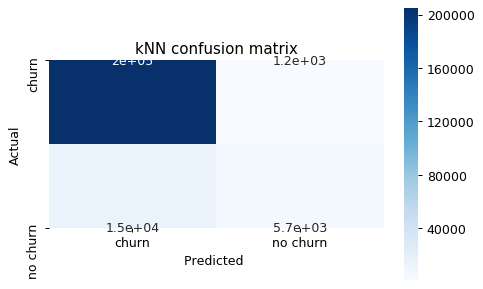

In [23]:
knn_confusion = confusion_matrix(label_test, knn.predict(X_test))
plt.figure(dpi=90)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['churn', 'no churn'],
           yticklabels=['churn', 'no churn'])

plt.xlabel('Predicted ')
plt.ylabel('Actual')
plt.title('kNN confusion matrix');

In [24]:
# Let's make a slightly better model

lm = LogisticRegression(C = 100)
lm.fit(X_train, label_train)
print("Logistic score: {:6.4f}".format(lm.score(X_train,label_train)))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic score: 0.9374


In [25]:
print('hfbfbnf')

hfbfbnf


In [26]:
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = lm.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(label_test, y_predict), 
                                                     recall_score(label_test, y_predict)))

Default threshold:
Precision: 0.9629,   Recall: 0.3148


In [27]:
y_predict = (lm.predict_proba(X_test)[:,1] > 0.06)
print("Threshold of 0.06:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(label_test, y_predict), 
                                                     recall_score(label_test, y_predict)))

Threshold of 0.06:
Precision: 0.1627,   Recall: 0.7762


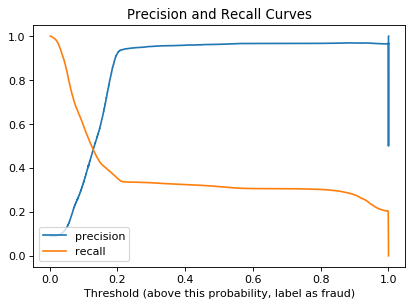

In [28]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(label_test, lm.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

base line for a logistic regression is very poor 

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(label_test, lm.predict_proba(X_test)[:,1])

ROC AUC score =  0.7884657540837763


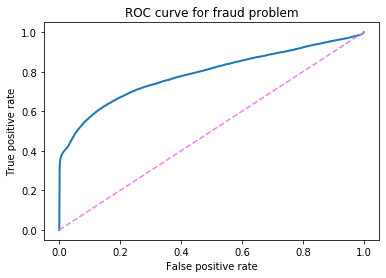

In [30]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(label_test, lm.predict_proba(X_test)[:,1]))



base line models 

In [32]:
print('dewf')

dewf


## model testing 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
#Data preparation for XGB
X_xgb = X
X_xgb_category = X_xgb.select_dtypes(include=['category'])

X_xgb = pd.get_dummies(data=X, columns=X_xgb_category.columns)
y_xgb = y.astype('int8')
X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(X_xgb, y_xgb, test_size=0.2)

In [38]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_pred_proba_logreg = logreg.predict_proba(X_test)
print('Logistic Regression log-loss : ' + str(log_loss(y_test, y_pred_proba_logreg)))

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)
print('Decision Tree Classifier log-loss : ' + str(log_loss(y_test, y_pred_proba_dt)))

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)
print('Random Forest Classifier log-loss : ' + str(log_loss(y_test, y_pred_proba_rf)))

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
y_pred_proba_gbc = gbc.predict_proba(X_test)
print('Gradient-Boosting Classifier log-loss : ' + str(log_loss(y_test, y_pred_proba_gbc)))

ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
y_pred_ada = ada.predict(X_test)
y_pred_proba_ada = ada.predict_proba(X_test)
print('AdaBoost Classifier log-loss : ' + str(log_loss(y_test, y_pred_proba_ada)))



/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression log-loss : 0.22212029816522483
Decision Tree Classifier log-loss : 2.0154695602827144


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Classifier log-loss : 0.4173812349449184
Gradient-Boosting Classifier log-loss : 0.11728253964337435
AdaBoost Classifier log-loss : 0.6530328476060403


In [59]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
fpr1, tpr1, thresholds1 = roc_curve(y_test,dt.predict_proba(X_test)[:,1])

fpr2, tpr2, thresholds2 = roc_curve(y_test,dt.predict_proba(X_test)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test,rf.predict_proba(X_test)[:,1])
fpr4, tpr4, thresholds4 = roc_curve(y_test,gbc.predict_proba(X_test)[:,1])









### cross val to check model consistency 


In [33]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score

for i in range(2,6):
    cv_score = cross_val_score(gbc, X_train, y_train, cv = i, scoring = 'neg_log_loss')
    print('log-loss score computed using ' + str(i) + '-fold cross-validation : {}'.format(cv_score.mean()))

log-loss score computed using 2-fold cross-validation : -0.11744983184130331
log-loss score computed using 3-fold cross-validation : -0.11761340487619228
log-loss score computed using 4-fold cross-validation : -0.1177128876009323
log-loss score computed using 5-fold cross-validation : -0.117799564591257


In [ ]:
### choose the best model (use xg boost)
### optimize for recall (yellow brick chart)
### confusion matrix 

### SMOTE - to handle imbalanced classes and check if log loss is further reduced 

In [41]:
X_train_small = X_train[:10000]
y_train_small = y_train[:10000]
X_test_small = X_test[:10000]
Y_test_small = y_test[:10000]





from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_smoted, y_smoted = sm.fit_sample(X_train, y_train.ravel())

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:628: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  return self._values.ravel(order=order)


In [42]:
Counter(y_smoted)

Counter({0: 549471, 1: 549471})

In [36]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_res,y_train_res )
y_pred_gbc = gbc.predict(X_test)
y_pred_proba_gbc = gbc.predict_proba(X_test)
print('Gradient-Boosting Classifier log-loss : ' + str(log_loss(y_test, y_pred_proba_gbc)))



Gradient-Boosting Classifier log-loss : 0.14831648930918967


## hyperparameter tuning in gbc using grid search 

In [27]:
print("hi")

hi


In [35]:
X_train_small = X_train[:10000]
y_train_small = y_train[:10000]
X_test_small = X_test[:10000]
Y_test_small = y_test[:10000]


In [36]:
from sklearn.model_selection import GridSearchCV

param_test_1 = {'n_estimators':range(50,401,50)}

gbc = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,
                                 max_depth=8,max_features='sqrt',subsample=0.8,random_state=10)

gbc_cv = GridSearchCV(gbc, param_grid = param_test_1, scoring = 'neg_log_loss', n_jobs = 4, cv = 5)
gbc_cv.fit(X_train_small,y_train_small)

print("Tuned Gradient Boosting Parameters: {}".format(gbc_cv.best_params_)) 
print("Best score is {}".format(gbc_cv.best_score_))


Tuned Gradient Boosting Parameters: {'n_estimators': 100}
Best score is -0.1367748959281899


#### here we can see that the best number of trees in the forest (n_estimator is 100)

In [24]:
param_test_2 = {'max_depth':range(4,11,1),'min_samples_split':range(600,1201,200)}
gbc = GradientBoostingClassifier(n_estimators = 50, learning_rate=0.1, min_samples_leaf = 50, max_features='sqrt',
                                 subsample=0.8,random_state=10)
gbc_cv = GridSearchCV(gbc, param_grid = param_test_2, scoring = 'neg_log_loss', n_jobs = 4, cv = 5)
gbc_cv.fit(X_train_small,y_train_small)

print("Tuned Gradient Boosting Parameters: {}".format(gbc_cv.best_params_)) 
print("Best score is {}".format(gbc_cv.best_score_))

Tuned Gradient Boosting Parameters: {'max_depth': 9, 'min_samples_split': 1000}
Best score is -0.12859381443089166


 ######    here we can see that the preferred depth of the tree should be 9 and the minimum number of samples to be recquired for split should be 1000 

In [25]:
param_test_3 = {'min_samples_leaf':range(1, 10, 2)}


gbc = GradientBoostingClassifier(n_estimators = 50, learning_rate=0.1, min_samples_split=1000,
                                 max_depth=9,max_features='sqrt',subsample=0.8,random_state=10)

gbc_cv = GridSearchCV(gbc, param_grid = param_test_3, scoring = 'neg_log_loss', n_jobs = 4, cv = 5)
gbc_cv.fit(X_train_small,y_train_small)

print("Tuned Gradient Boosting Parameters: {}".format(gbc_cv.best_params_)) 
print("Best score is {}".format(gbc_cv.best_score_))


Tuned Gradient Boosting Parameters: {'min_samples_leaf': 1}
Best score is -0.12390452275258726


In [26]:
param_test_4 = {'max_features':range(5,31,2)}


gbc = GradientBoostingClassifier(n_estimators = 50, learning_rate=0.1, min_samples_split=1000,
                                 max_depth=9, min_samples_leaf = 3 , subsample=0.8, random_state=10)

gbc_cv = GridSearchCV(gbc, param_grid = param_test_4, scoring = 'neg_log_loss', n_jobs = 4, cv = 5)
gbc_cv.fit(X_train_small, y_train_small)

print("Tuned Gradient Boosting Parameters: {}".format(gbc_cv.best_params_)) 
print("Best score is {}".format(gbc_cv.best_score_))



Tuned Gradient Boosting Parameters: {'max_features': 25}
Best score is -0.12309481667845869


In [27]:
param_test_5 = {'subsample':[0.85, 0.9, 0.95]}


gbc = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, min_samples_split = 1000,
                                 max_depth = 9, min_samples_leaf = 3 , max_features = 25, random_state = 10)

gbc_cv = GridSearchCV(gbc, param_grid = param_test_5, scoring = 'neg_log_loss', n_jobs = 4, cv = 5)
gbc_cv.fit(X_train_small,y_train_small)

print("Tuned Gradient Boosting Parameters: {}".format(gbc_cv.best_params_)) 
print("Best score is {}".format(gbc_cv.best_score_))


Tuned Gradient Boosting Parameters: {'subsample': 0.85}
Best score is -0.12328888709708244


using all the best selected parameter to test on the testing set 

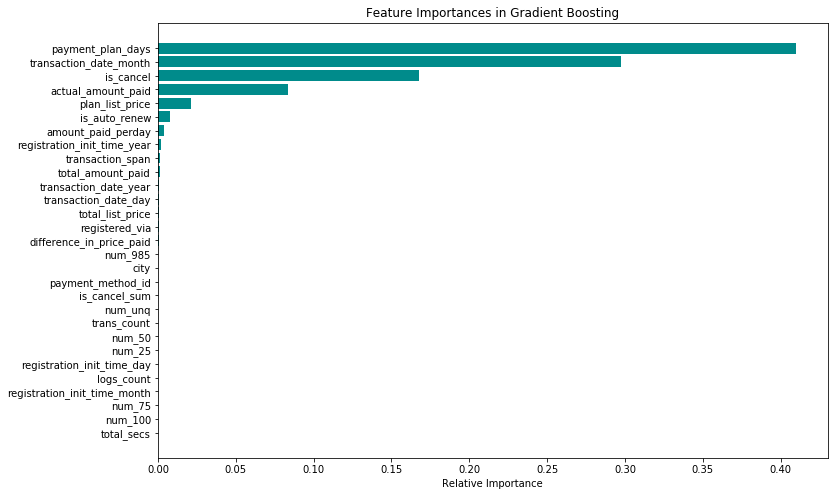

In [30]:
plt.figure(figsize=(12,8))
features = X_train.columns
importances = gbm_tuned_1.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances in Gradient Boosting')
plt.barh(range(len(indices)), importances[indices], color='darkcyan', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

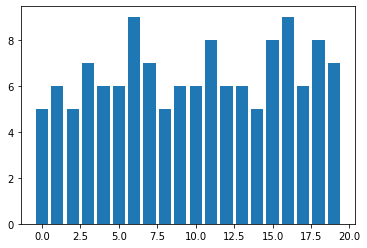

In [31]:
new_x = []
new_y = np.random.randint(5,10,20)

plt.bar(new_x,new_y);